# 📰 AG News Dataset: Exploratory Data Analysis

## Setup and Dataset Initialization

In [21]:
import os

# Detect Colab environment
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

REPO_URL = "https://github.com/jvillar-sheff/AI-News-Classification.git"
REPO_DIR = "/content/AI-News-Classification"

if IN_COLAB:
    print("📌 Running in Colab")

    # Clone repo if missing
    if not os.path.exists(REPO_DIR):

        print("\n🔐 GitHub authentication required.")
        print("👉 If your repo is private, create a Personal Access Token at:")
        print("   https://github.com/settings/tokens (Classic, repo scope)")

        from getpass import getpass
        token = getpass("Enter your GitHub token (leave blank if repo is public): ")

        # If token provided → private repo
        if token.strip():
            os.environ["GITHUB_TOKEN"] = token.strip()
            print("\n📥 Cloning private repository...")
            !git clone https://$GITHUB_TOKEN@github.com/jvillar-sheff/AI-News-Classification.git {REPO_DIR}
        else:
            print("\n📥 Cloning public repository...")
            !git clone {REPO_URL} {REPO_DIR}

    else:
        print("\n📁 Repository already exists, pulling latest changes...")
        os.chdir(REPO_DIR)
        !git pull

    os.chdir(REPO_DIR)
    print("\n📂 Working directory:", os.getcwd())
    print("📄 Files available:", os.listdir())

else:
    print("📌 Running locally (VS Code / Jupyter) — using local repository")


📌 Running in Colab

📁 Repository already exists, pulling latest changes...
Already up to date.

📂 Working directory: /content/AI-News-Classification
📄 Files available: ['.git', 'README.md']


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from datasets import load_dataset
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

# -------------------------
# Global Pretty Chart Styling
# -------------------------

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 130

sns.set_theme(style="whitegrid", palette="pastel")

# -------------------------
# Pretty table helper
# -------------------------

def pretty(df, precision=2):
    """Return a readable, Word-friendly styled table."""
    return (
        df.style
        .format(precision=precision)
        .set_table_styles([
            {'selector': 'th',
             'props': [('background-color', '#d3d3d3'),
                       ('font-weight', 'bold'),
                       ('color', 'black'),
                       ('padding', '8px'),
                       ('border', '1px solid #a0a0a0')]},

            {'selector': 'td',
             'props': [('padding', '6px'),
                       ('border', '1px solid #c0c0c0'),
                       ('color', 'black'),
                       ('background-color', 'white')]},
        ])
        .set_properties(subset=pd.IndexSlice[:, :], **{
            "text-align": "left",
            "color": "black"
        })
        .apply(lambda col: ['background-color: #f2f2f2' if i % 2 else 'background-color: white'
                            for i in range(len(col))], axis=0)
    )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
# Ensure required NLTK resources are available
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

In [24]:
# Load the AG News dataset from Hugging Face
dataset = load_dataset("ag_news")

# Use the 'train' split for EDA
df = dataset["train"].to_pandas()

# Map numeric labels to readable category names
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
df["category"] = df["label"].map(label_map)

df.head()

,text,label,category
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


## Raw Data Analysis

This section performs **exploratory data analysis (EDA)** on the raw text of the Hugging Face `ag_news` dataset **before any cleaning or tokenization**.

The goals are:
- Understand text length, word counts, and sentence counts
- Inspect dataset balance and category-wise length differences
- Analyze case usage (uppercase vs lowercase)
- Identify punctuation and special character patterns
- Examine vocabulary and word length characteristics
- Perform data quality checks (nulls, duplicates, very short texts)

A later section will define the **preprocessing + tokenization pipeline** once the raw data is fully understood.

### Null / Missing Value & Basic Quality Checks

In [25]:
nulls = df.isnull().sum()
dupes = df.duplicated(subset=["text"]).sum()

summary = pd.DataFrame({
    "Missing Values": nulls,
    "Duplicate Text Count": [dupes] + [""] * (len(nulls) - 1)
}, index=nulls.index)

pretty(summary)

,Missing Values,Duplicate Text Count
text,0,0
label,0,
category,0,


### Dataset Overview & Label Distribution

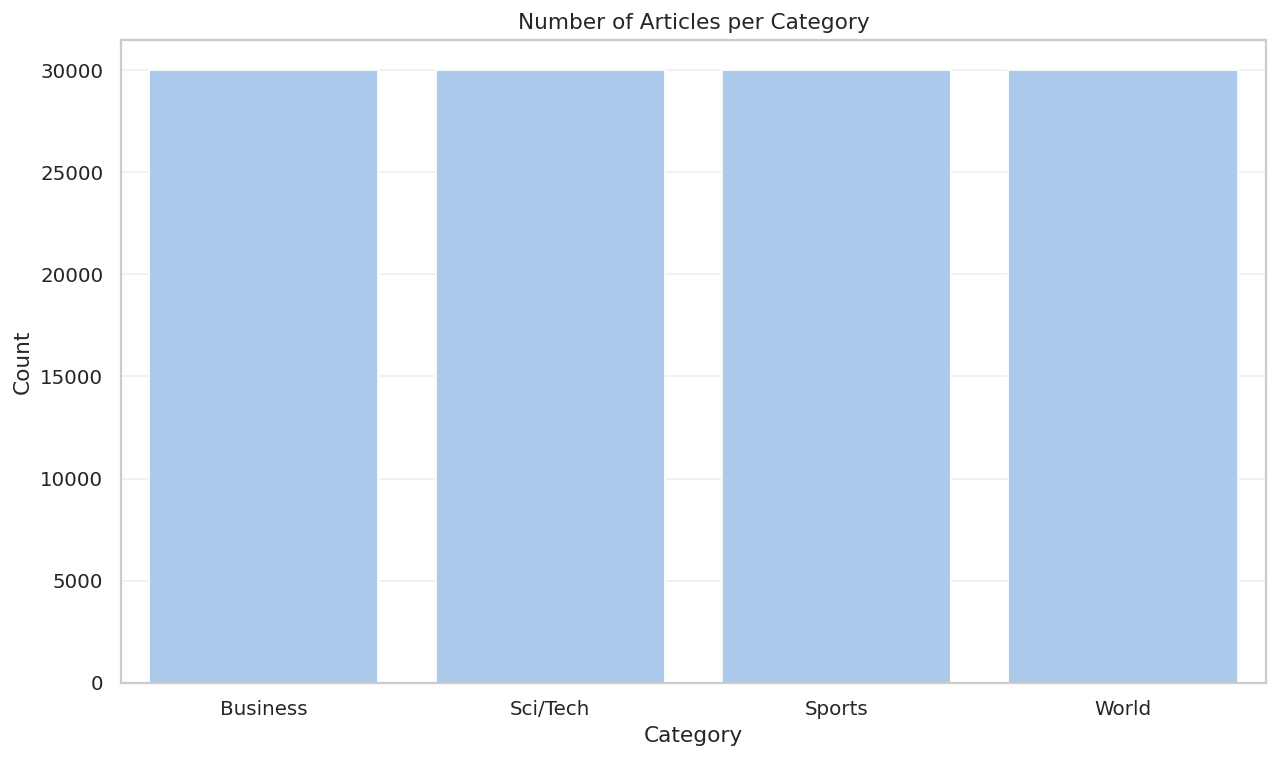

In [26]:
counts = df["category"].value_counts().sort_index()
pretty(counts.to_frame("Count"))

plt.figure()
sns.barplot(x=counts.index, y=counts.values)
plt.title("Number of Articles per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [27]:
df["num_chars"] = df["text"].str.len()
df["num_words"] = df["text"].str.split().str.len()

pretty(df[["num_chars", "num_words"]].describe())

,num_chars,num_words
count,120000.00,120000.00
mean,236.48,37.85
std,66.51,10.09
min,100.00,8.00
25%,196.00,32.00
50%,232.00,37.00
75%,266.00,43.00
max,1012.00,177.00


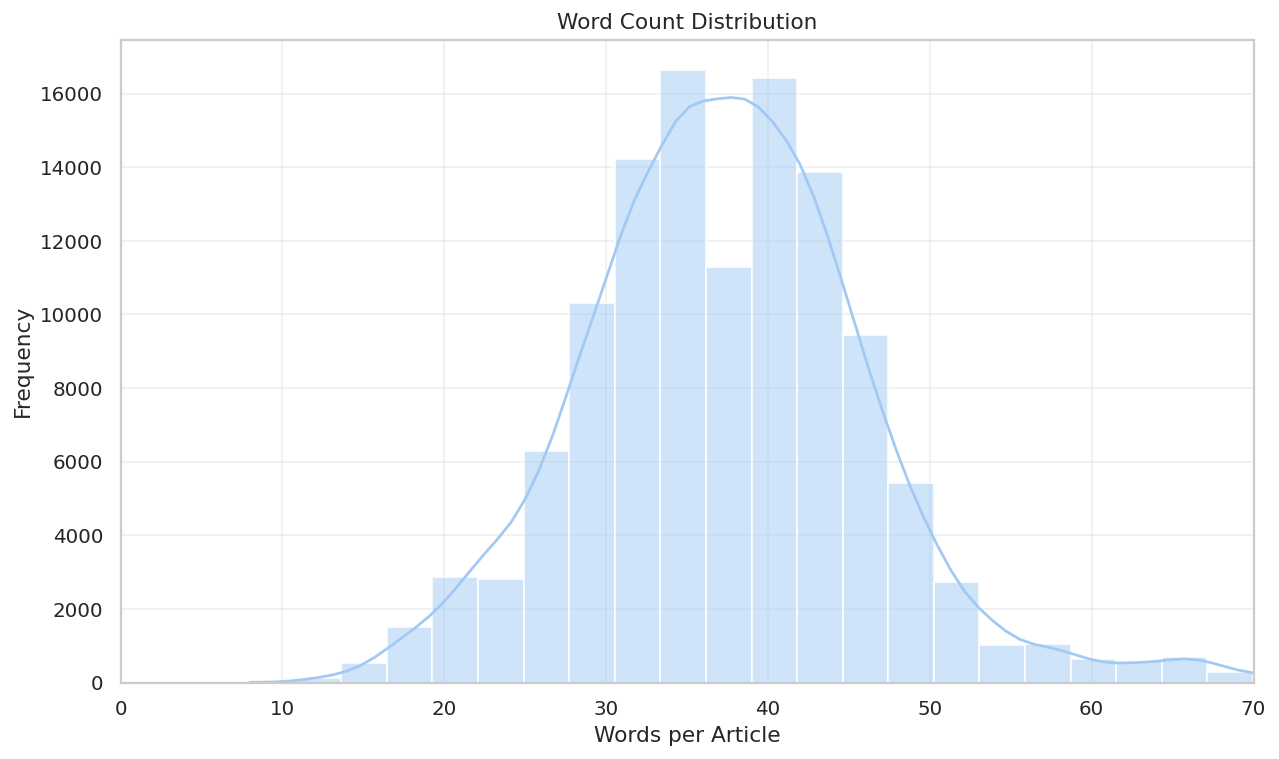

In [28]:
plt.figure()
sns.histplot(df["num_words"], bins=60, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Words per Article")
plt.ylabel("Frequency")
plt.xlim(0, df["num_words"].quantile(0.99))
plt.tight_layout()
plt.show()

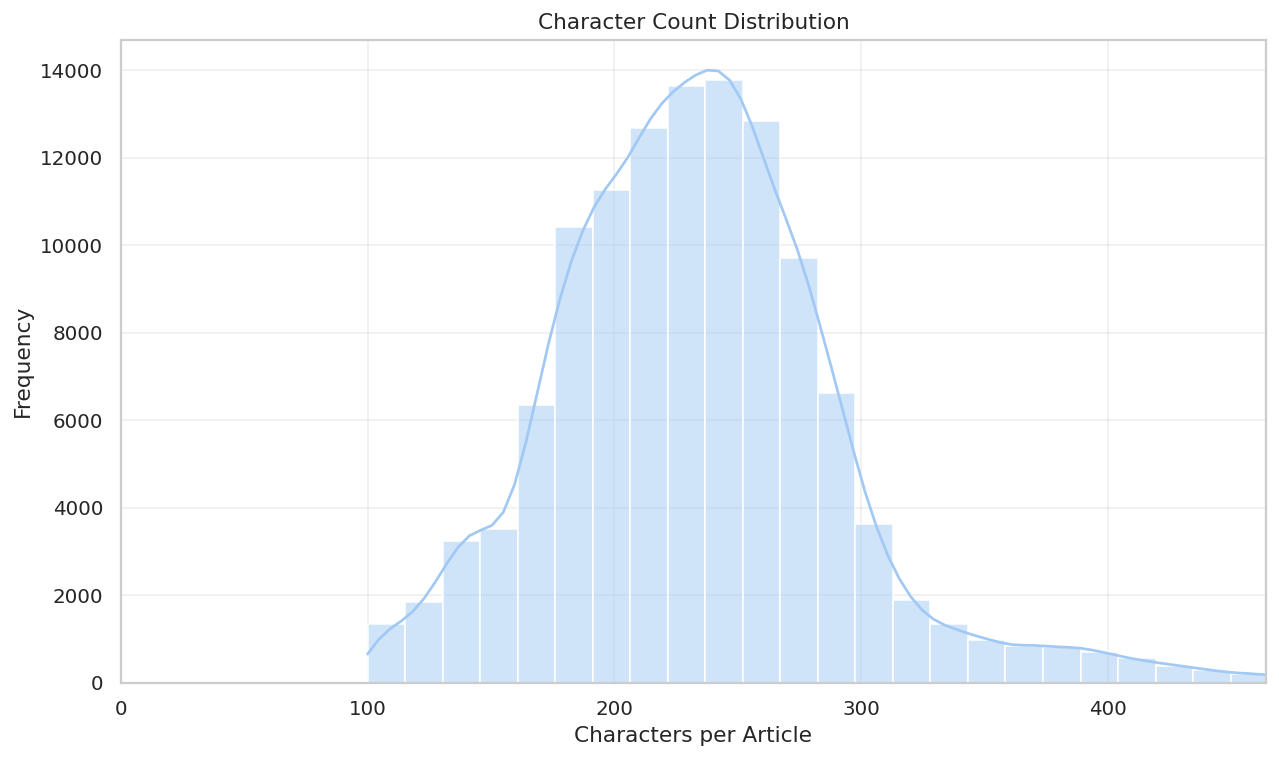

In [29]:
plt.figure()
sns.histplot(df["num_chars"], bins=60, kde=True)
plt.title("Character Count Distribution")
plt.xlabel("Characters per Article")
plt.ylabel("Frequency")
plt.xlim(0, df["num_chars"].quantile(0.99))
plt.tight_layout()
plt.show()

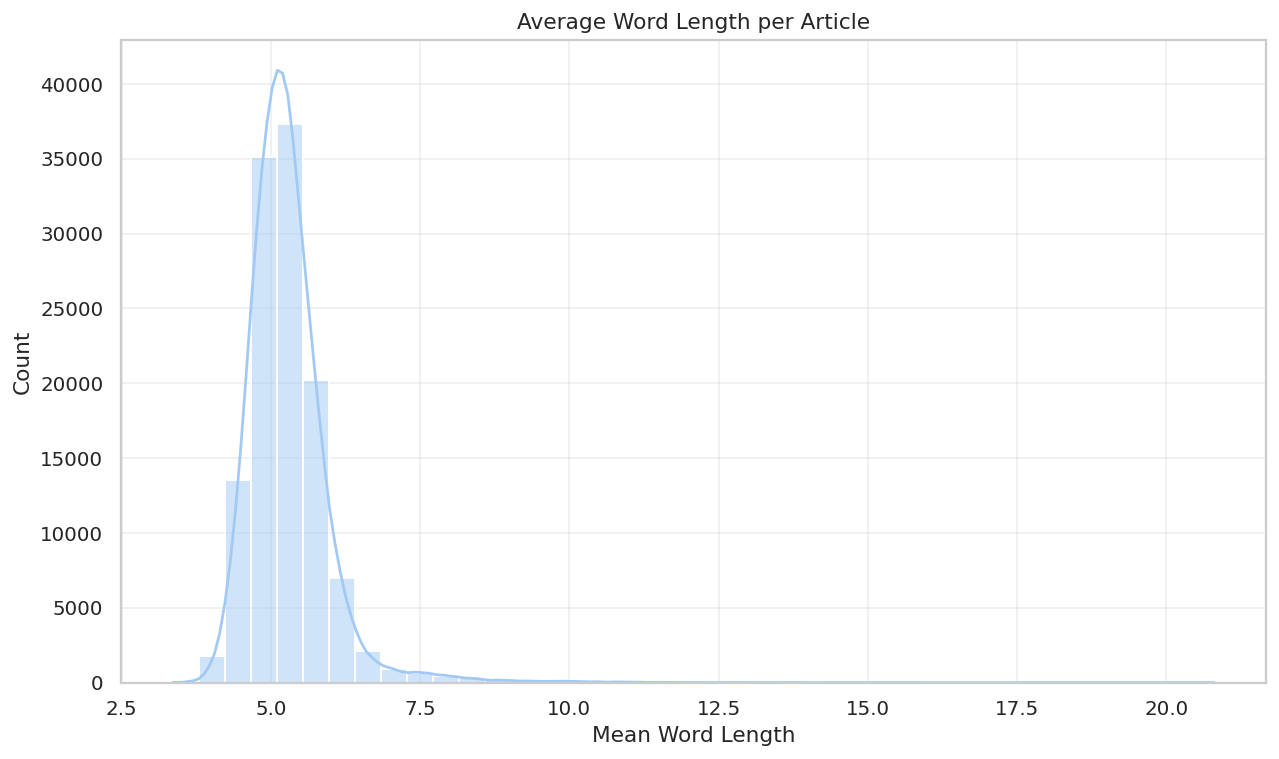

In [30]:
def avg_word_len(text):
    words = text.split()
    return np.mean([len(w) for w in words]) if words else 0

df["avg_word_len_article"] = df["text"].apply(avg_word_len)

pretty(df["avg_word_len_article"].describe().to_frame("avg_word_len"))

plt.figure()
sns.histplot(df["avg_word_len_article"], bins=40, kde=True)
plt.title("Average Word Length per Article")
plt.xlabel("Mean Word Length")
plt.tight_layout()
plt.show()

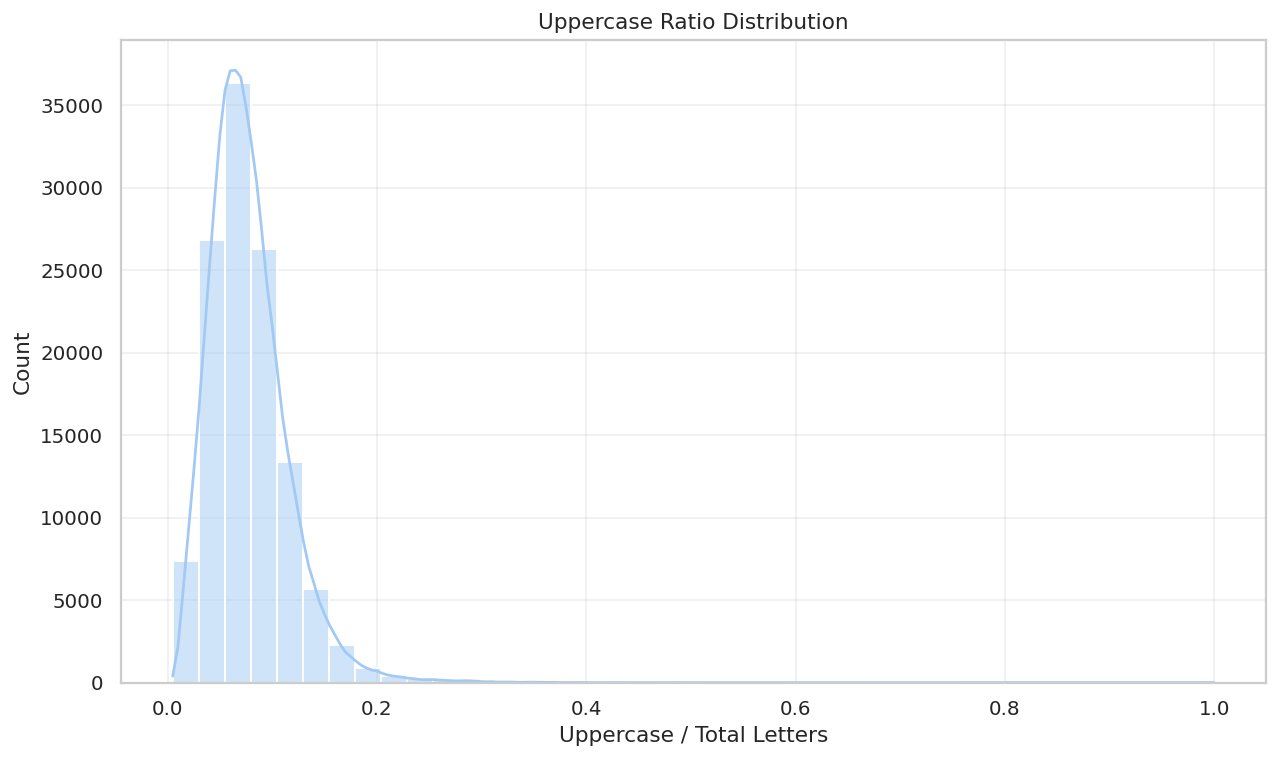

In [31]:
df["num_upper"] = df["text"].str.count(r"[A-Z]")
df["num_lower"] = df["text"].str.count(r"[a-z]")
df["upper_ratio"] = df["num_upper"] / (df["num_upper"] + df["num_lower"]).replace(0, np.nan)

pretty(df[["num_upper", "num_lower", "upper_ratio"]].describe())

plt.figure()
sns.histplot(df["upper_ratio"].dropna(), bins=40, kde=True)
plt.title("Uppercase Ratio Distribution")
plt.xlabel("Uppercase / Total Letters")
plt.tight_layout()
plt.show()

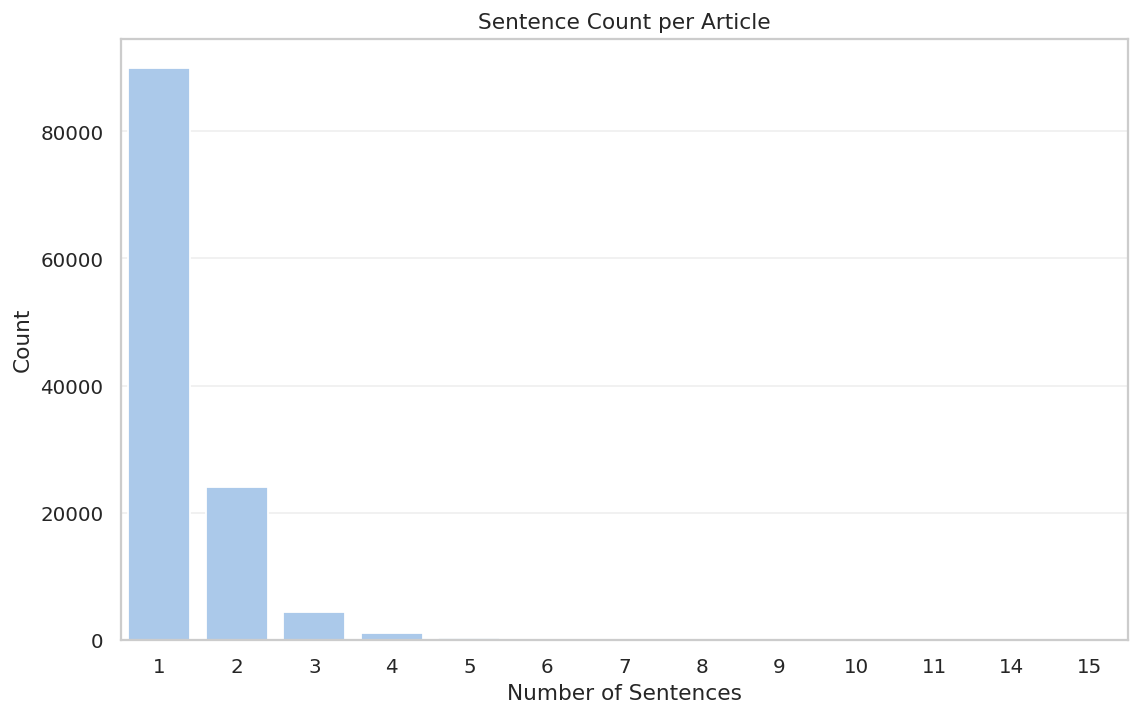

In [32]:
df["num_sentences"] = df["text"].apply(lambda x: len(sent_tokenize(x)))

pretty(df["num_sentences"].describe().to_frame("sentence_count"))

plt.figure(figsize=(10,6))
sns.countplot(x=df["num_sentences"])
plt.title("Sentence Count per Article")
plt.xlabel("Number of Sentences")
plt.ylabel("Count")
plt.show()

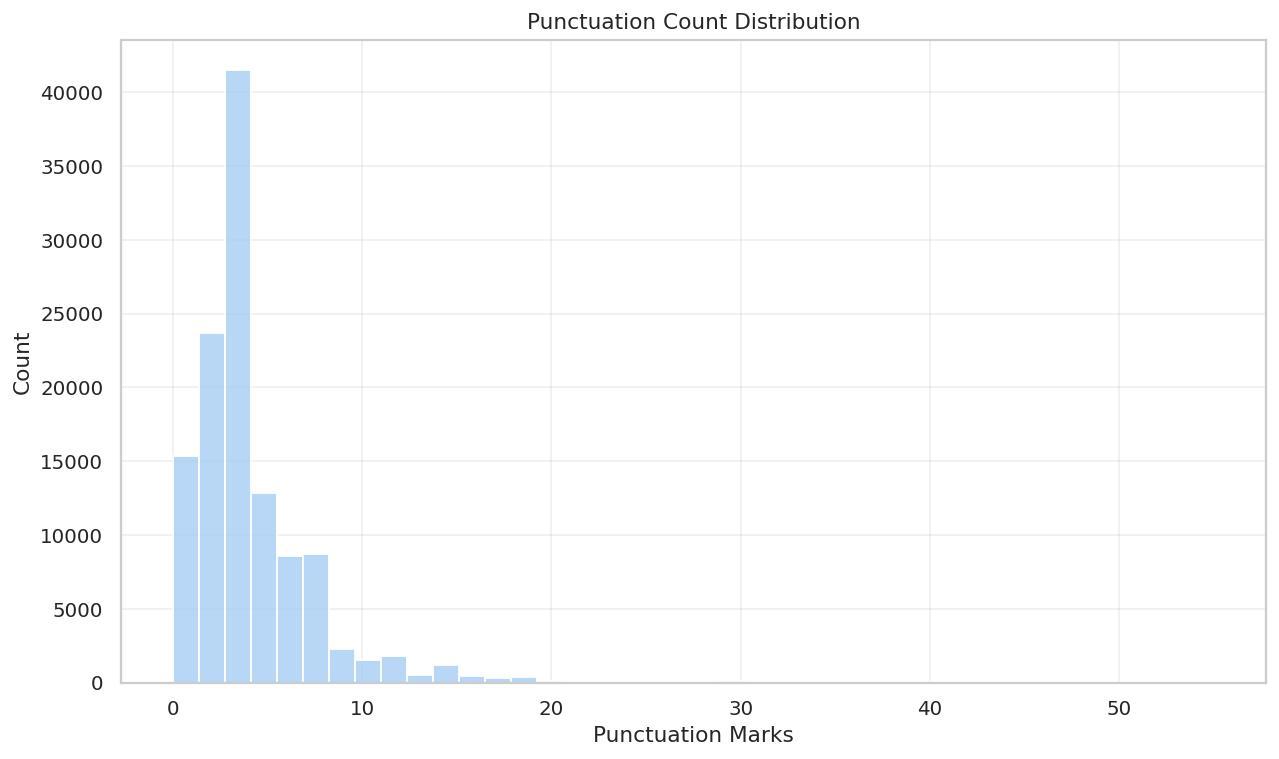

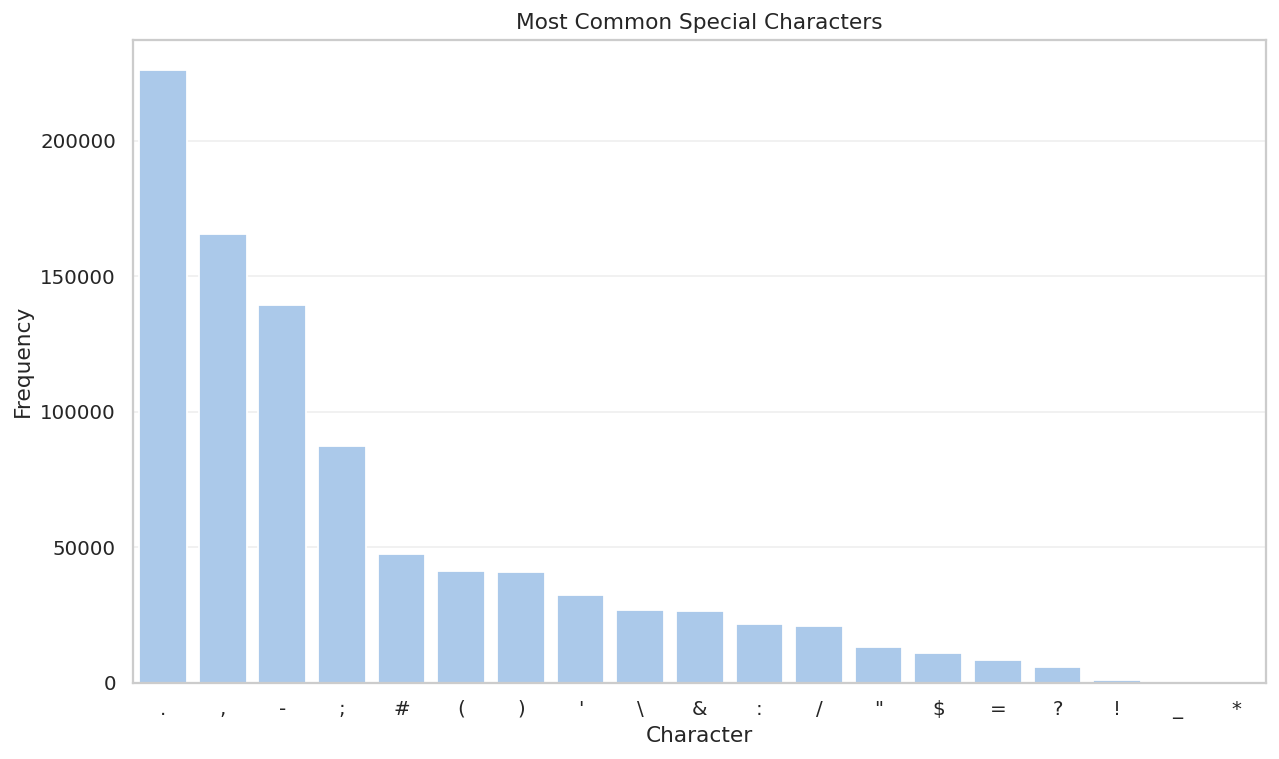

In [33]:
df["num_punct"] = df["text"].str.count(r"[.,;:!?]")

pretty(df["num_punct"].describe().to_frame("punctuation_count"))

plt.figure()
sns.histplot(df["num_punct"], bins=40)
plt.title("Punctuation Count Distribution")
plt.xlabel("Punctuation Marks")
plt.tight_layout()
plt.show()

specials = df["text"].str.findall(r"[^a-zA-Z0-9\s]").explode()
top_specials = specials.value_counts().head(25)

pretty(top_specials.to_frame("Frequency"))

plt.figure()
sns.barplot(x=top_specials.index.astype(str), y=top_specials.values)
plt.title("Most Common Special Characters")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


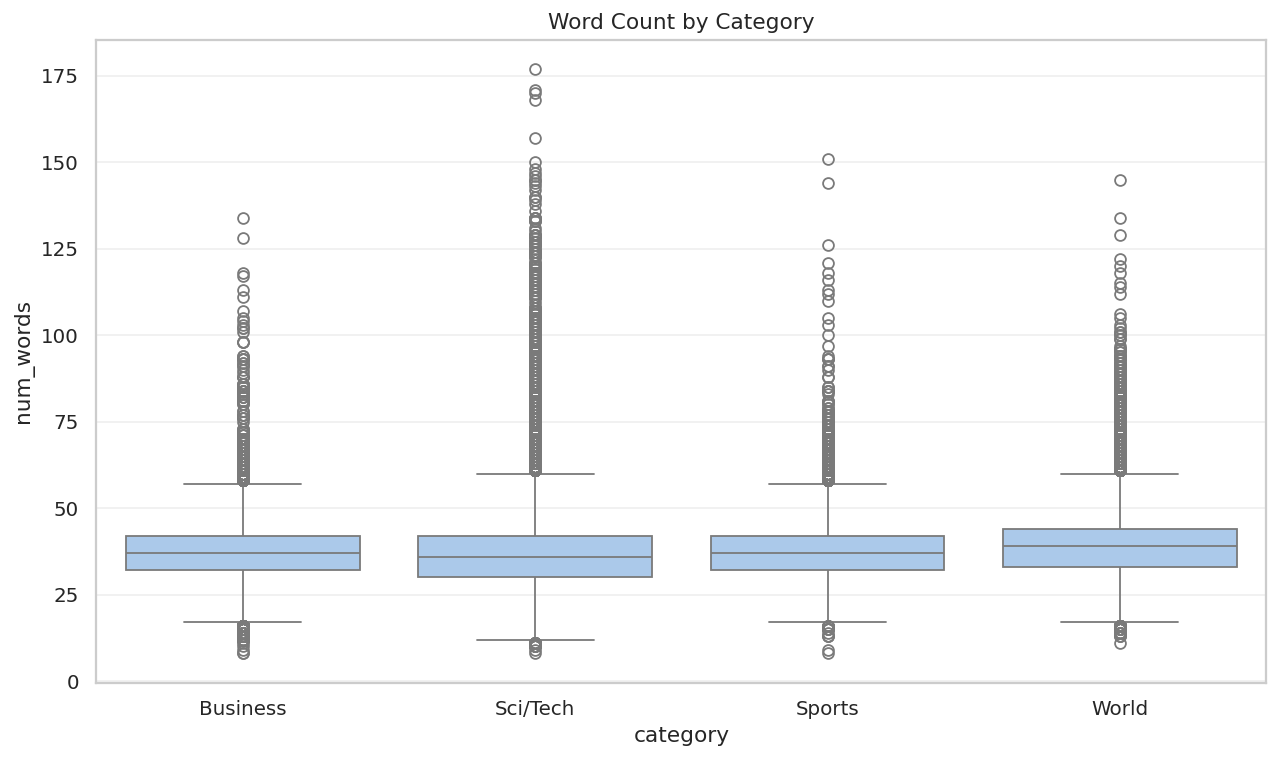

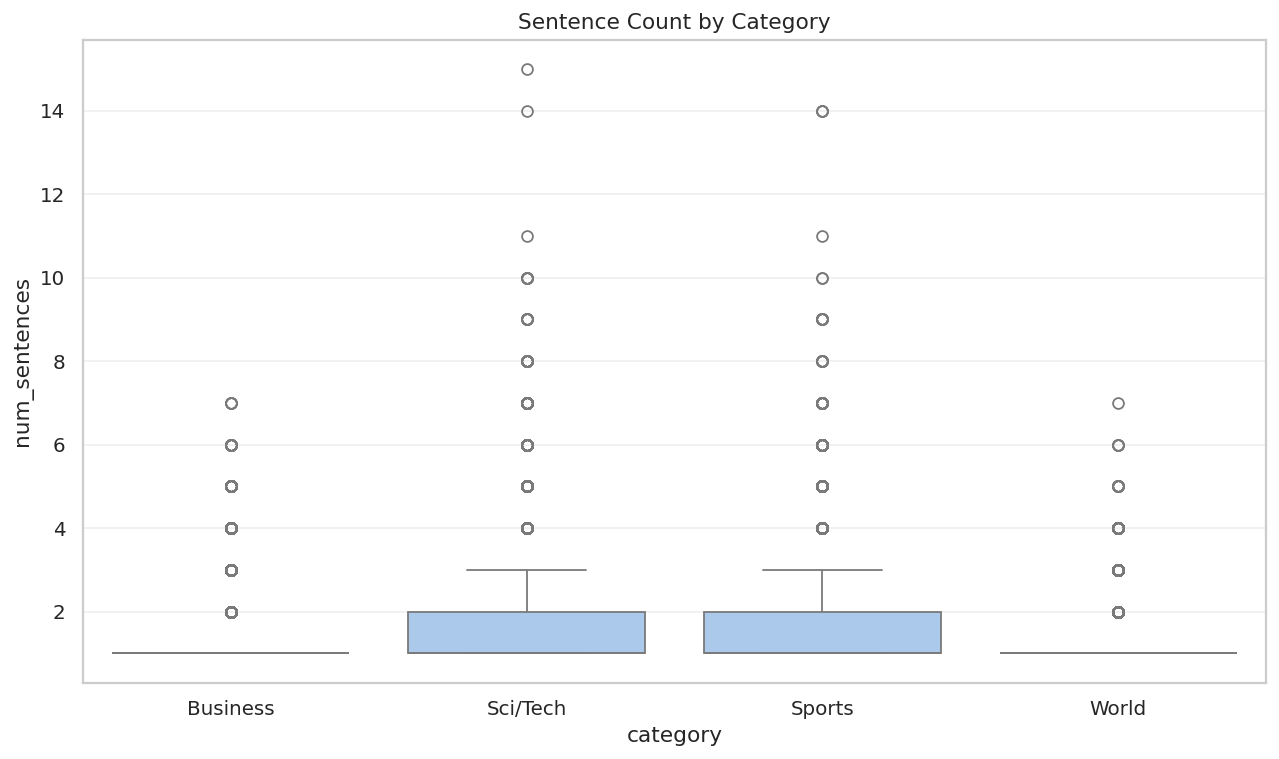

In [34]:
group_stats = df.groupby("category")[["num_chars", "num_words", "num_sentences", "avg_word_len_article"]].agg(["mean","median","std"])
pretty(group_stats)

plt.figure()
sns.boxplot(data=df, x="category", y="num_words")
plt.title("Word Count by Category")
plt.tight_layout()
plt.show()

plt.figure()
sns.boxplot(data=df, x="category", y="num_sentences")
plt.title("Sentence Count by Category")
plt.tight_layout()
plt.show()


In [35]:
all_text = " ".join(df["text"])
tokens = re.findall(r"[A-Za-z0-9]+", all_text)
vocab = set(tokens)
freq = Counter(tokens)

vocab_summary = pd.DataFrame({
    "Total Tokens": [len(tokens)],
    "Vocabulary Size": [len(vocab)]
})

pretty(vocab_summary)

,Total Tokens,Vocabulary Size
0,4759095,88095


In [36]:
top_words = freq.most_common(25)
pretty(pd.DataFrame(top_words, columns=["Token", "Count"]))

,Token,Count
0,the,179006
1,to,119192
2,a,99359
3,of,98172
4,in,93106
5,and,69058
6,on,56402
7,s,53669
8,for,48982
9,39,44506


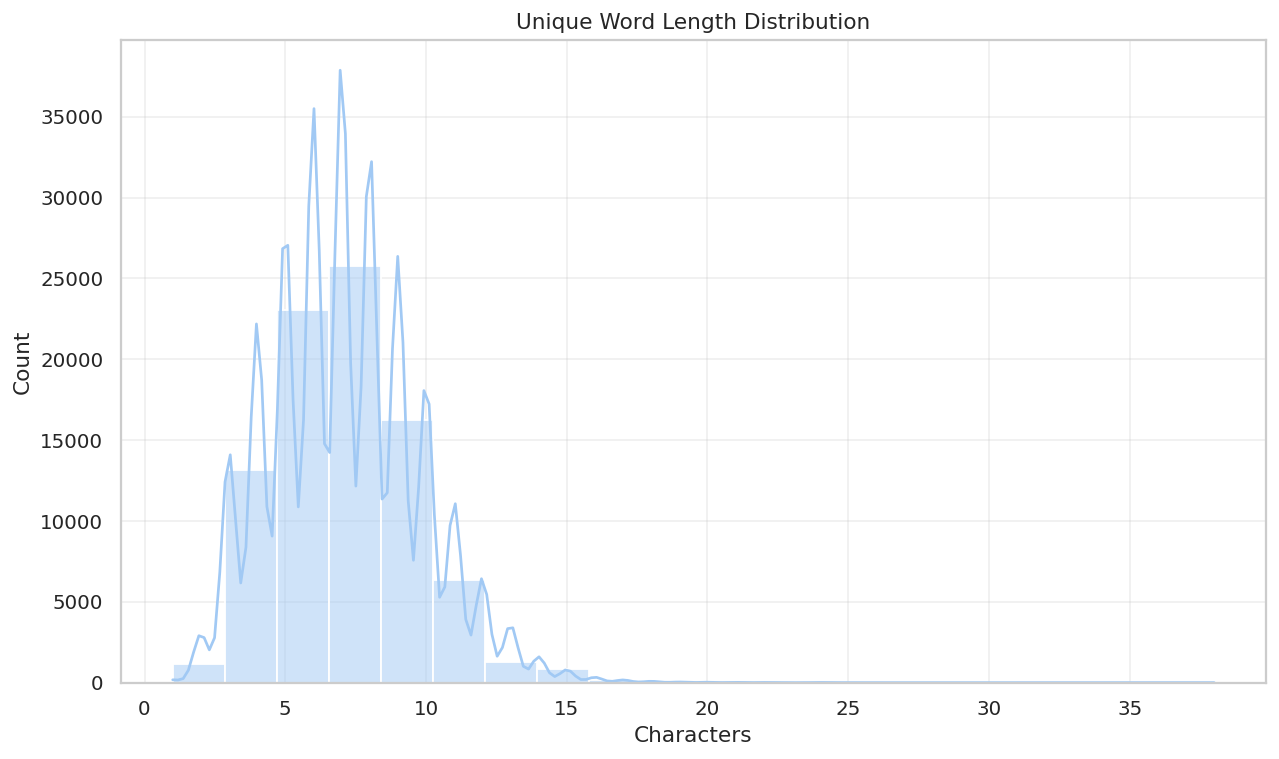

In [37]:
word_lengths = pd.Series([len(w) for w in vocab])

pretty(word_lengths.describe().to_frame("word_length"))

plt.figure()
sns.histplot(word_lengths, bins=20, kde=True)
plt.title("Unique Word Length Distribution")
plt.xlabel("Characters")
plt.tight_layout()
plt.show()


In [38]:
short = df[df["num_words"] <= 5][["text", "category", "num_words"]]
long  = df[df["num_words"] >= 200][["text", "category", "num_words"]]

print("Very short articles (<= 5 words):", len(short))
display(short.head())

print("\nVery long articles (>= 200 words):", len(long))
display(long.head())


Very short articles (<= 5 words): 0


,text,category,num_words



Very long articles (>= 200 words): 0


,text,category,num_words


## Preprocessing and Tokenization (To Be Implemented Later)

Now that we have a good understanding of the **raw text**, we can design a preprocessing pipeline.

Based on the analysis above, a reasonable pipeline might include:

1. **Unicode normalization** and whitespace cleanup
2. Optional **lowercasing** (depending on whether case carries useful signal)
3. Handling or normalization of **special characters** identified in the EDA
4. Optional **stopword removal** (for classical models; usually not for modern transformers)
5. **Sentence-level vs document-level granularity** decisions based on sentence counts
6. Choice of tokenizer (e.g., Hugging Face BPE/WordPiece tokenizer) and maximum sequence length,
   informed by word/character length distributions.

The actual implementation of these steps and the tokenizer itself will be done in the next section, using this EDA as justification for each design choice.
